# KNN with HOG Image Predictor

This notebook loads a trained KNN model (using HOG features) and predicts custom images.
No training required - just load the saved model and predict!

## Model Details:
- **Input Size**: 48x48 grayscale images
- **Feature Extraction**: HOG (orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2))
- **Classifier**: KNN with n_neighbors=5
- **Model File**: `knn_hog_model_48x48.joblib`

## 1. Import Required Libraries

In [8]:
# Import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
from skimage.feature import hog
from sklearn.neighbors import KNeighborsClassifier

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration - Set Your Paths

Update these paths to match your setup:
- `BASE_PATH`: Root folder for your dataset
- `RESULTS_PATH`: Folder where model is saved
- `model_filepath`: Path to the saved KNN model file

In [9]:
# Configuration - Set your paths here
BASE_PATH = '/home/ubuntu/Desktop/AIML project/AlphaNum2'
TRAIN_PATH = os.path.join(BASE_PATH, "train")
RESULTS_PATH = '/home/ubuntu/Desktop/AIML project/results/KNN'
model_filename = 'knn_hog_model_48x48.joblib'
model_filepath = os.path.join(RESULTS_PATH, model_filename)

# Image specifications (must match training setup)
IMG_HEIGHT = 48
IMG_WIDTH = 48

# HOG parameters (must match training setup)
HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'visualize': False
}

print(f"Model path: {model_filepath}")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH} grayscale")
print(f"HOG params: {HOG_PARAMS}")

# Verify paths exist
if os.path.exists(model_filepath):
    print("✓ Model file found!")
else:
    print("❌ Model file not found! Please check the path.")

if os.path.exists(TRAIN_PATH):
    print("✓ Training path found!")
else:
    print("❌ Training path not found! Please check the path.")

Model path: /home/ubuntu/Desktop/AIML project/results/KNN/knn_hog_model_48x48.joblib
Image size: 48x48 grayscale
HOG params: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2), 'visualize': False}
✓ Model file found!
✓ Training path found!


## 3. Load Class Names

In [10]:
# Get class names from training folder
class_names = sorted([d for d in os.listdir(TRAIN_PATH) if os.path.isdir(os.path.join(TRAIN_PATH, d))])
num_classes = len(class_names)

print(f"✓ Found {num_classes} classes")
print(f"\nFirst 10 classes: {class_names[:10]}")
print(f"Last 10 classes: {class_names[-10:]}")

# Show character mapping for ASCII-based classes
print("\n📋 Character Mapping (first 10):")
for i, cls in enumerate(class_names[:10]):
    if cls.isdigit():
        if cls == '999':
            print(f"  Class {cls} → 'Null Class'")
        else:
            ascii_val = int(cls)
            char = chr(ascii_val) if 32 <= ascii_val <= 126 else cls
            print(f"  Class {cls} → '{char}'")

✓ Found 53 classes

First 10 classes: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109']
Last 10 classes: ['85', '86', '87', '88', '89', '90', '97', '98', '99', '999']

📋 Character Mapping (first 10):
  Class 100 → 'd'
  Class 101 → 'e'
  Class 102 → 'f'
  Class 103 → 'g'
  Class 104 → 'h'
  Class 105 → 'i'
  Class 106 → 'j'
  Class 107 → 'k'
  Class 108 → 'l'
  Class 109 → 'm'


## 4. Load Trained KNN Model

In [11]:
# Load the trained KNN model
try:
    knn_model = joblib.load(model_filepath)
    print(f"✓ Model loaded successfully from: {model_filepath}")
    print(f"📊 Model type: {type(knn_model).__name__}")
    print(f"🎯 Number of neighbors (k): {knn_model.n_neighbors}")
    print(f"📐 Expected feature dimension: {knn_model.n_features_in_}")
    print(f"\n✓ Model ready for predictions!")
except Exception as e:
    print(f"❌ Error loading model: {str(e)}")
    print(f"Please check that the model file exists at: {model_filepath}")

✓ Model loaded successfully from: /home/ubuntu/Desktop/AIML project/results/KNN/knn_hog_model_48x48.joblib
📊 Model type: KNeighborsClassifier
🎯 Number of neighbors (k): 5
📐 Expected feature dimension: 900

✓ Model ready for predictions!


## 5. Image Preprocessing and HOG Feature Extraction

In [12]:
def load_and_preprocess_image(image_path):
    """
    Load and preprocess image for prediction.
    
    Args:
        image_path: Path to the image file
    
    Returns:
        tuple: (original_image, resized_image) or (None, None) if error
    """
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"❌ Error: Unable to load image from {image_path}")
        return None, None
    
    # Resize to 48x48
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    return img, img_resized

def extract_hog_features(image):
    """
    Extract HOG features from preprocessed image.
    
    Args:
        image: Preprocessed grayscale image (48x48)
    
    Returns:
        HOG feature vector
    """
    features = hog(image, **HOG_PARAMS)
    return features

print(" Image preprocessing and HOG extraction functions defined")

 Image preprocessing and HOG extraction functions defined


## 6. Prediction Function with Visualization

In [13]:
def predict_image_with_details(image_path, show_neighbors=5, show_full_details=False):
    """
    Predict image class and show detailed results with visualization.
    
    Args:
        image_path: Path to the image to predict
        show_neighbors: Number of nearest neighbors to show (default: 5)
        show_full_details: If True, shows neighbor distances and voting details. If False, shows only percentages (default: False)
    """
    # Check if image exists
    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return
    
    # Load and preprocess image
    original_img, resized_img = load_and_preprocess_image(image_path)
    
    if original_img is None:
        return
    
    # Extract HOG features
    hog_features = extract_hog_features(resized_img)
    
    # Reshape for prediction (models expect 2D array)
    features_reshaped = hog_features.reshape(1, -1)
    
    # Get prediction and probabilities
    predicted_class = knn_model.predict(features_reshaped)[0]
    
    # Get distances and indices of k nearest neighbors
    distances, indices = knn_model.kneighbors(features_reshaped, n_neighbors=show_neighbors)
    
    # Get neighbor labels and map them to actual class labels (ASCII codes)
    # The model's classes_ attribute contains the mapping from indices to ASCII codes
    neighbor_indices = knn_model._y[indices[0]]
    if hasattr(knn_model, 'classes_'):
        # Map neighbor indices to actual ASCII codes
        neighbor_labels = np.array([knn_model.classes_[idx] for idx in neighbor_indices])
    else:
        # Fallback: assume labels are already ASCII codes
        neighbor_labels = neighbor_indices
    
    # Convert predicted class to character
    if predicted_class == 999:
        predicted_char = 'NULL'
    elif predicted_class == 0:
        predicted_char = 'NULL'  # ASCII 0 is null character
    elif 32 <= predicted_class <= 126:
        predicted_char = chr(predicted_class)  # Printable ASCII
    else:
        predicted_char = f'[ASCII {predicted_class}]'  # Non-printable
    
    # Convert neighbor labels to characters
    neighbor_chars = []
    for label in neighbor_labels:
        if label == 999:
            neighbor_chars.append('NULL')
        elif label == 0:
            neighbor_chars.append('NULL')  # ASCII 0 is null character
        elif 32 <= label <= 126:
            neighbor_chars.append(chr(label))
        else:
            neighbor_chars.append(f'[ASCII {label}]')
    
    # Count votes for each class among neighbors
    from collections import Counter
    vote_counts = Counter(neighbor_labels)
    total_votes = len(neighbor_labels)
    
    # Visualization
    fig = plt.figure(figsize=(16, 5))
    
    # 1. Original image
    ax1 = plt.subplot(1, 4, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f'Original Image\n{original_img.shape[1]}x{original_img.shape[0]}', 
              fontsize=11, fontweight='bold')
    plt.axis('off')
    
    # 2. Resized image
    ax2 = plt.subplot(1, 4, 2)
    plt.imshow(resized_img, cmap='gray')
    plt.title(f'Preprocessed\n{IMG_HEIGHT}x{IMG_WIDTH} Grayscale', 
              fontsize=11, fontweight='bold')
    plt.axis('off')
    
    # 3. HOG visualization
    ax3 = plt.subplot(1, 4, 3)
    hog_features_viz, hog_image = hog(
        resized_img, 
        orientations=HOG_PARAMS['orientations'],
        pixels_per_cell=HOG_PARAMS['pixels_per_cell'],
        cells_per_block=HOG_PARAMS['cells_per_block'],
        visualize=True
    )
    plt.imshow(hog_image, cmap='gray')
    plt.title(f'HOG Features\n{len(hog_features)} dimensions', 
              fontsize=11, fontweight='bold')
    plt.axis('off')
    
    # 4. Nearest neighbors voting
    ax4 = plt.subplot(1, 4, 4)
    vote_data = sorted(vote_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    labels_to_plot = []
    counts_to_plot = []
    
    for label, count in vote_data:
        if label == 999:
            char = 'NULL'
        elif label == 0:
            char = 'NULL'
        elif 32 <= label <= 126:
            char = chr(label)
        else:
            char = f'[{label}]'
        labels_to_plot.append(f"{char}\n({label})")
        counts_to_plot.append(count)
    
    colors = ['green' if i == 0 else 'lightblue' for i in range(len(labels_to_plot))]
    bars = plt.barh(range(len(labels_to_plot)), counts_to_plot, color=colors, alpha=0.8)
    plt.yticks(range(len(labels_to_plot)), labels_to_plot, fontsize=9)
    plt.xlabel('Votes from K Nearest Neighbors', fontsize=10)
    plt.title(f'Top Predictions\n(k={show_neighbors})', fontsize=11, fontweight='bold')
    plt.xlim(0, show_neighbors)
    plt.gca().invert_yaxis()
    
    # Add count labels on bars
    for i, count in enumerate(counts_to_plot):
        plt.text(count + 0.1, i, f'{count}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print prediction summary - Simple version (only percentages)
    if not show_full_details:
        print("\n" + "="*70)
        print(f"🎯 PREDICTING IMAGE: {os.path.basename(image_path)}")
        print("="*70)
        
        # Display the actual predicted character based on model prediction
        print(f"\n🎯 Predicted Character: '{predicted_char}' (ASCII: {predicted_class})")
        
        # Get top 5 predictions sorted by vote count
        top_5_predictions = sorted(vote_counts.items(), key=lambda x: x[1], reverse=True)[:5]
        
        print(f"\n🏆 TOP {min(5, len(top_5_predictions))} PREDICTIONS (from {show_neighbors} neighbors):")
        for rank, (label, count) in enumerate(top_5_predictions, 1):
            if label == 999:
                char = 'NULL'
            elif 32 <= label <= 126:
                # Printable ASCII character
                char = chr(label)
            elif label == 0:
                char = 'NULL'  # ASCII 0 is null character
            else:
                # Non-printable character, show ASCII code
                char = f'[ASCII {label}]'
            percentage = 100 * count / total_votes
            
            # Mark the actual prediction with an indicator
            marker = " ← PREDICTED" if label == predicted_class else ""
            print(f"   {rank}. '{char}' (ASCII: {label}) - {percentage:.2f}%{marker}")
        print("="*70)
    else:
        # Print full details version
        print("\n" + "="*80)
        print("🎯 PREDICTION RESULT")
        print("="*80)
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Original Size: {original_img.shape[1]}x{original_img.shape[0]}")
        print(f"Preprocessed Size: {IMG_HEIGHT}x{IMG_WIDTH}")
        print(f"HOG Feature Dimension: {len(hog_features)}")
        print("-" * 80)
        print(f"Predicted Character: '{predicted_char}'")
        print(f"Predicted Class (ASCII): {predicted_class}")
        print(f"Confidence: {vote_counts[predicted_class]}/{total_votes} neighbors agree ({100*vote_counts[predicted_class]/total_votes:.1f}%)")
        print("="*80)
        
        print(f"\n📊 K-Nearest Neighbors (k={show_neighbors}):")
        for i, (label, char, dist) in enumerate(zip(neighbor_labels, neighbor_chars, distances[0]), 1):
            print(f"  {i}. '{char}' (class: {label}) - Distance: {dist:.4f}")
        
        print("\n🗳️  Voting Summary:")
        for label, count in sorted(vote_counts.items(), key=lambda x: x[1], reverse=True):
            if label == 999:
                char = 'Null'
            else:
                char = chr(label) if 32 <= label <= 126 else str(label)
            print(f"  '{char}' (class: {label}): {count} votes ({100*count/total_votes:.1f}%)")
        print("="*80)

print("✓ Prediction function defined")

✓ Prediction function defined


## 7. Predict Single Custom Image

**Change the image path below to predict your own image!**

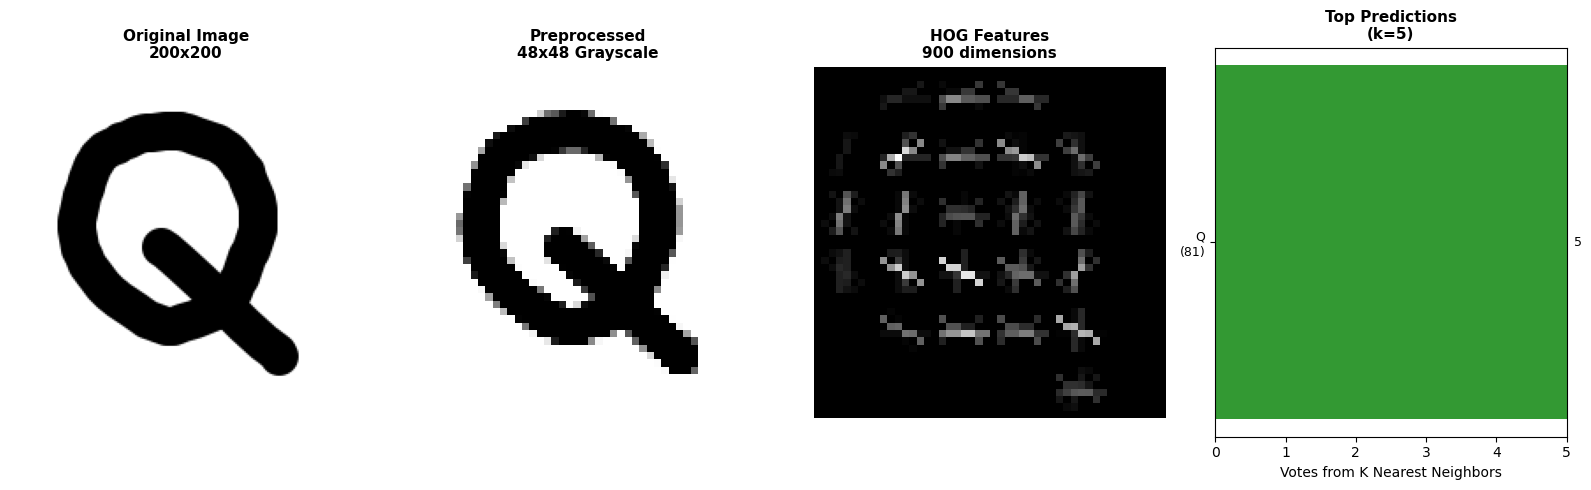


🎯 PREDICTING IMAGE: asaad.png

🎯 Predicted Character: 'Q' (ASCII: 81)

🏆 TOP 1 PREDICTIONS (from 5 neighbors):
   1. 'Q' (ASCII: 81) - 100.00% ← PREDICTED


In [14]:
# CHANGE THIS PATH TO YOUR IMAGE
custom_image_path = '/home/ubuntu/Pictures/asaad.png'

# Run prediction with simple output (only percentages)
predict_image_with_details(custom_image_path, show_neighbors=5, show_full_details=False)

# If you want to see full details with distances and neighbor info, use:
# predict_image_with_details(custom_image_path, show_neighbors=5, show_full_details=True)